In [91]:
import numpy as np
from scipy.stats import multivariate_normal
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

# Gaussian Proccesses

Topics to be covered:
 - The heuristic behind linear regression
 - MAP and MLE
 - The Bayesian heuristic for Gaussian Processes
 - Multivariate Gaussian
 - 
 

## Multivariate Gaussian Distribution

A univariate guassian distribution is parametrized by two parameters:
 - 1.) Mean $\mu$ = expresses expectation of $x$
 - 2.) Standard deviation $\sigma$ = expresses uncertainty of $x$

$x$ ~ $N(\mu, \sigma)$

A multivariate gaussian distribution is parametrized by the same parameters as above, but in vector and matrix space:
 - 1.) Mean $\vec{\mu}$
 - 2.) Standard deviation = covariance matrix $\sum$

$x$ ~ $N(\vec{\mu}, \sum)$

One of the properties of the gaussian distribution is that it is like the _black hole_ of distributions. When you:
 - Add two gaussians =  GD
 - Marginalize = GD
 - Product = GD
 - Subtract = GD



In [92]:
# Multivariate gaussian distribution
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
x, y = np.meshgrid(x, y)

# Well, technically this example is a bivariate distribution w/covariance between x1 and x2 
covariance = np.array([[1, 0.6],
                      [0.6, 1]])

x_mu = 0
y_mu = 0

x_variance = 0.6
y_variance = 0.6

pos = np.empty(x.shape+(2, ))
pos[:,:,0] = x
pos[:,:,1] = y

rv = multivariate_normal([x_mu, y_mu], covariance)

In [93]:
fig = go.Figure(data = [go.Surface(x = x, y = y, z = rv.pdf(pos))])
fig.update_layout(title='Multivariate Gaussian Distribution', width=720, height=600)
fig.show()

### Marginal Distribution

The marginal distribution of a multivariate gaussian is defined by the integral over the dimension we want to marginalize over. Given this multivairate joint distribution:

$p(x, y) = N({\begin{pmatrix} \mu_x \\ \mu_y \end{pmatrix}})$ . . .

The marginal distribution is acquired by simply reprameterizing the lower dimensional gaussian with the variable $x$, or $y$ that you want the marginal of which is $\mu_x$, $\sum_x$:

$p(x) = \int p(x, y) dy = N(\mu_x, \sum_x)$

### Conditional Distribution

The conditional distribution is parameterized by:

$p(x|y) = N(\mu_{x|y}, \sum_{x|y})$

## Gaussian Processes

$P(y | x, D) = \int_w P(y | x, w) * P(w | D) dw$

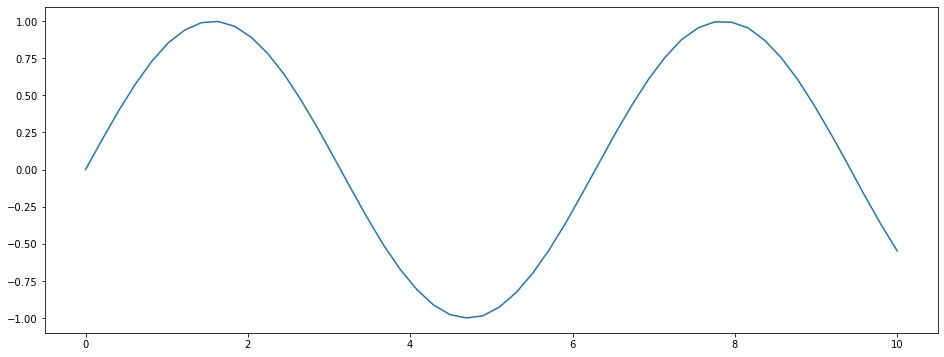

In [94]:
n = 50
x = np.linspace(0, 10, n)

# Data
norm = multivariate_normal(mean=np.sin(x), cov=np.eye(n) * 1e-6)
plt.figure(figsize=(16, 6))
plt.plot(x, norm.rvs())
plt.show()

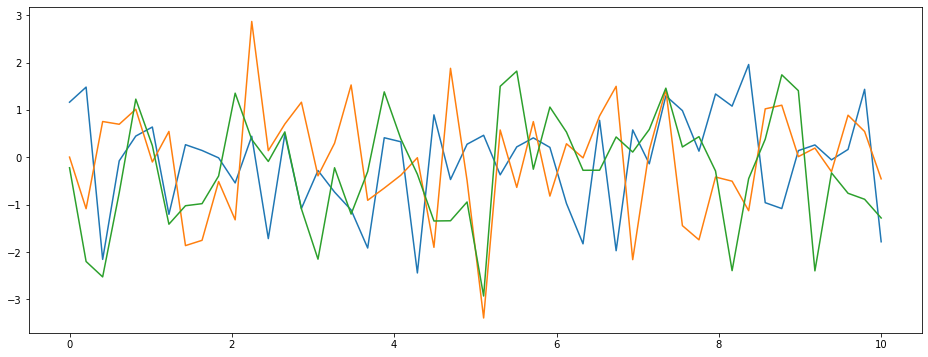

In [95]:
# 3 samples from our gaussian process - zero mean and zero correlation
norm = multivariate_normal(mean=np.zeros(n), cov=np.eye(n))
plt.figure(figsize=(16, 6))

[plt.plot(x, norm.rvs()) for _ in range(3)]
plt.show()

### The **Prior Probability**

Defining a prior over the functions consists of defining the mean and covariance matrix (computed with the kernel parameters)

### Covariance and Kernel Matrix

Assume one training point and one testing point, what does it mean they are drawn from a GD?
 - If we say they are GD, then that means if I know the label of the training point, then that informs me about the label of the test point

But how do we represent this using our features? With the covariance matrix!!
 - Similar values are to have large values and non-similar values to have small values
 - I.e., If my neighbor just sold his house for a lot of money, and I know my house is similar, then my house is likely to sell for a lot too

_Critical Point_ - The covariance matrix, $\sum$, is a positive semi-definite matrix! Where have we seen these before? KERNELS!! Gaussian processes can be kernelized.

In [113]:
# Squared Exponential Kernel (radial basis function) - The Brad Pitt of Kernels
def kernel(m1, m2, l=1):
    """
    l = hyperparameter that leads to smoother or non-smoother functions
        High values = smoother
        low values  = higher variance and more uncertainty in between training points 
    """
    return np.exp(-1 / (2 * l**2) * (m1[:, None] - m2) ** 2)

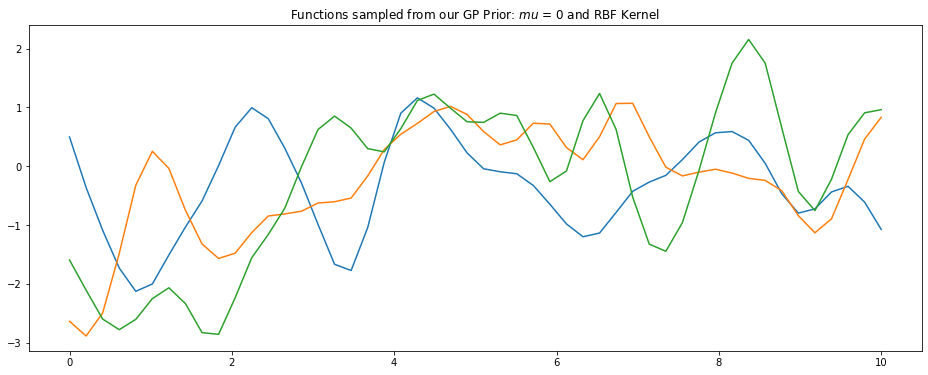

In [166]:
## Prior ##
n = 50
x = np.linspace(0, 10, n)

# Covariance matrix is now parameterized using our RBF kernel
cov = kernel(x, x, 0.44)

# Mean = 0 and cov is now parameterized with our kernel
norm = multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16, 6))
[plt.plot(x, norm.rvs()) for _ in range(3)]
plt.title('Functions sampled from our GP Prior: $mu$ = 0 and RBF Kernel')
plt.show()

## Predictive Posterior Distribution

$p(f_* | X_*, X, f) = N(f_* | \mu_*, \sum_*)$ 

where:

$\mu_* =$. . . .

In [133]:
from numpy.linalg import inv

def posterior(x_s, X_train, y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Args: 
        x_s = new input locations (n x d)
        X_train = training inputs (m x d)
        y_train = training targets (m x 1)
        l = kernel length parameter
        sigma_f = kernel vertical variation parameter
        sigma_y = noise parameter

    returns:
            Posterior mean vector (n x d) and covariance matrix (n x n)
    """

    K = kernel(X_train, X_train, l)
    K_s = kernel(X_train, x_s, l)
    K_ss = kernel(x_s, x_s, l)
    K_inv = inv(K)

    mu_s = K_s.T.dot(K_inv).dot(y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

In [ ]:
# True function of our data
f = lambda x: np.sin(x)
X_train = np.random.uniform(0, 10, 5)
y_train = f(X_train)
plt.figure(figsize=(16, 6))
plt.scatter(X_train, y_train)
plt.xlim(0, 10)
plt.show()

In [167]:
n = 200

# Testing points - domain our predicted function will infer from
x_s = np.linspace(0, 10, n)

# Training points - values our GP will have already seen and thus should have no uncertainty (noise-free)
f = lambda x: np.sin(x)
X_train = np.random.uniform(0, 10, 5)
y_train = f(X_train)

# Posterior inference
mu_s, cov_s = posterior(x_s, X_train, y_train)

In [168]:
# Which makes sense b/c mu should be a column vector and the kernel should be a matrix
mu_s.shape, cov_s.shape

((200,), (200, 200))

In [172]:
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 10)

In [182]:
# Remember the covariance matrix - you can compute uncertainty by taking sqrt of diagional of the kernel
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

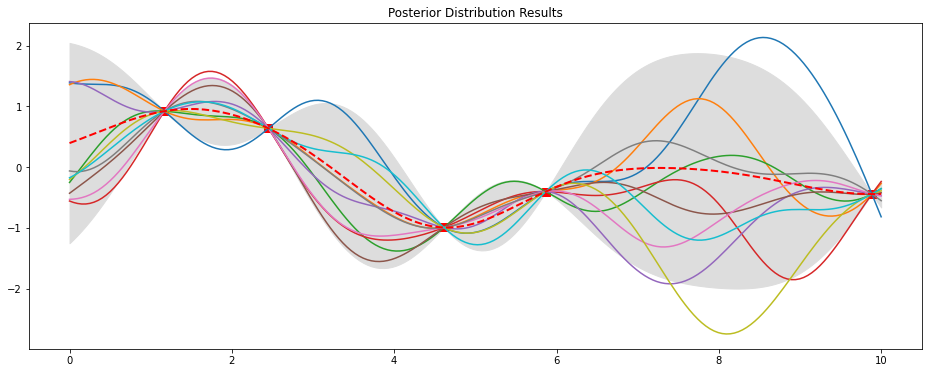

In [183]:
plt.figure(figsize=(16, 6))
plt.plot(X_train, f(X_train), 'bs', ms=8, color='red')
[plt.plot(x_s, sample) for sample in samples]
plt.fill_between(x_s, mu_s + uncertainty, mu_s - uncertainty, color='#dddddd' )
plt.plot(x_s, mu_s, 'r--', lw=2)
plt.title('Posterior Distribution Results')
plt.show()